In [84]:
import scanpy as sc
import drug2cell as d2c
import pandas as pd


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip



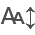

In [85]:
!pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [86]:
!pip install python-igraph louvain



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [157]:
adata = sc.read_h5ad("/Users/mennayoussef/Downloads/macrophageAF_subset.h5ad")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [158]:
adata

AnnData object with n_obs × n_vars = 13957 × 33911
    obs: 'Region', 'Sex', 'Age', 'Age_Range', 'Cell_or_Nuclei', 'Disease', 'Study', 'Study_Batch', 'Study_Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mito', 'log1p_total_counts_Mito', 'pct_counts_Mito', 'stressScore', 'Indiv', 'n_genes', 'n_counts', 'Donor', 'batch', 'batch2', 'General_Region', 'Foetal Cluster', 'Adult Cluster', 'Cluster', 'Foetal Cell Type', 'Cell Type i', 'Cell Type ii', 'Cell Type', 'NCM Cell Type'
    var: 'gene_symbols-2', 'Mito-2', 'Mito-3', 'Mito-4', 'gene_symbols-5', 'Mito-5', 'gene_symbols-6', 'Mito-6', 'n_cells', 'Mito', 'gene_symbols', 'Mito-0', 'gene_symbols-0-0', 'n_cells_by_counts-0-0', 'mean_counts-0-0', 'log1p_mean_counts-0-0', 'pct_dropout_by_counts-0-0', 'total_counts-0-0', 'log1p_total_counts-0-0', 'n_cells-0-0', 'n_c

In [159]:
# Recompute PCA, neighbors, and UMAP
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)  # <== This recomputes UMAP layout

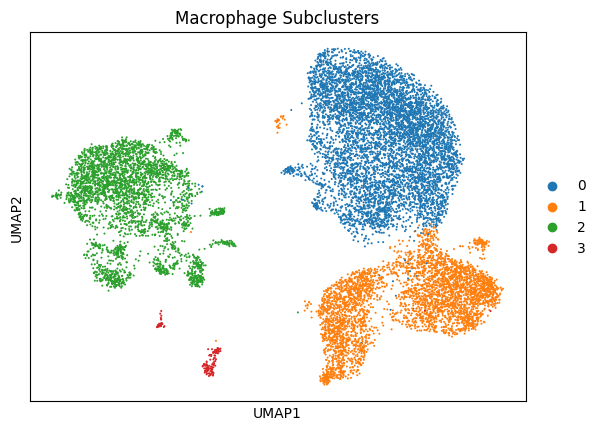

In [162]:
sc.tl.louvain(adata, resolution=0.1)  # Adjust resolution for granularity
sc.pl.umap(adata, color="louvain", title="Macrophage Subclusters")


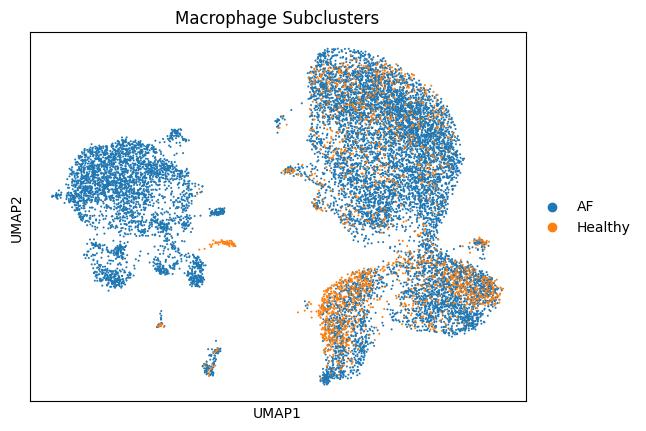

In [160]:
sc.pl.umap(adata, color="Disease", title="Macrophage Subclusters")

In [163]:

# Group by Louvain clusters and gender, then count cells
gender_cluster_counts = adata.obs.groupby(["louvain", "Sex"]).size().unstack(fill_value=0)

# Calculate proportions per cluster
gender_cluster_proportions = gender_cluster_counts.div(gender_cluster_counts.sum(axis=1), axis=0)

# Display the table
print(gender_cluster_proportions)


Sex        Female      Male
louvain                    
0        0.053216  0.946784
1        0.036866  0.963134
2        0.001467  0.998533
3        0.125000  0.875000


/var/folders/2f/yz7m9qg90v7802vshvdt7grr0000gn/T/ipykernel_45720/2154510824.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_cluster_counts = adata.obs.groupby(["louvain", "Sex"]).size().unstack(fill_value=0)


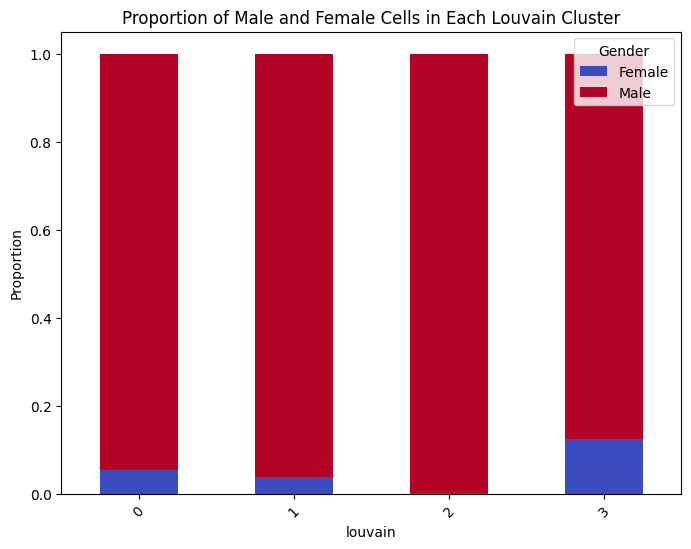

In [164]:
import matplotlib.pyplot as plt

# Plot stacked bar chart
gender_cluster_proportions.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="coolwarm")
plt.ylabel("Proportion")
plt.title("Proportion of Male and Female Cells in Each Louvain Cluster")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


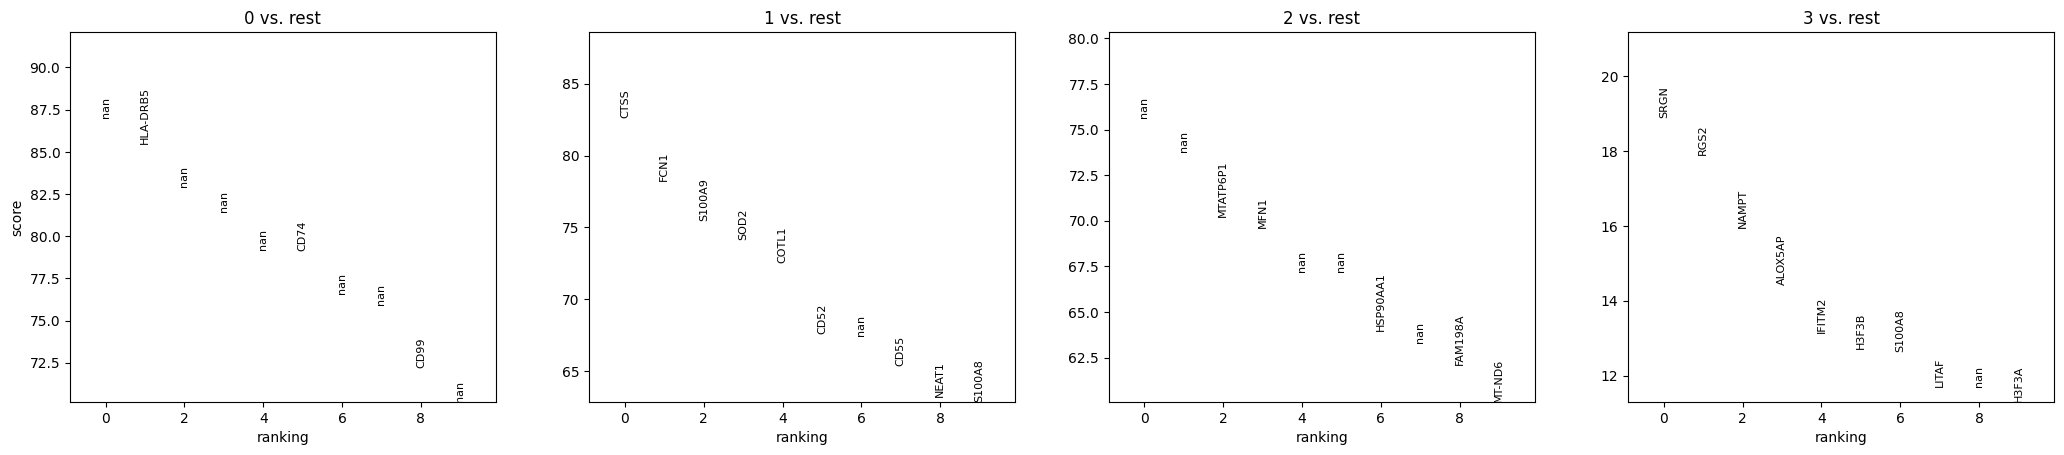

In [165]:

sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")  
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)  # Visualize top 10 markers


In [166]:

# Run differential expression analysis
sc.tl.rank_genes_groups(adata, groupby="louvain", method="wilcoxon")

# Convert results into a DataFrame
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names  # Get cluster names

# Extract top 10 marker genes per cluster
top_genes = {cluster: result["names"][cluster][:10] for cluster in groups}

# Convert to DataFrame
df = pd.DataFrame(top_genes)
df.to_csv("macrophage_markers.csv", index=False)  # Save to CSV
df


0       1         2        3
0       nan    CTSS       nan     SRGN
1  HLA-DRB5    FCN1       nan     RGS2
2       nan  S100A9  MTATP6P1    NAMPT
3       nan    SOD2      MFN1  ALOX5AP
4       nan   COTL1       nan   IFITM2
5      CD74    CD52       nan    H3F3B
6       nan     nan  HSP90AA1   S100A8
7       nan    CD55       nan    LITAF
8      CD99   NEAT1   FAM198A      nan
9       nan  S100A8    MT-ND6    H3F3A

In [128]:
# Identify mitochondrial genes (usually start with "MT-" for human)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate percentage of mitochondrial reads
adata.obs['percent_mt'] = (adata[:, adata.var['mt']].X.sum(axis=1) / adata.X.sum(axis=1)) * 100

# Compute average % mitochondria per Louvain cluster
mito_per_cluster = adata.obs.groupby('louvain')['percent_mt'].mean()
print(mito_per_cluster)


louvain
0    1.724170
1    1.825468
2    2.041489
3    2.750821
Name: percent_mt, dtype: float64


/var/folders/2f/yz7m9qg90v7802vshvdt7grr0000gn/T/ipykernel_45720/3054603393.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mito_per_cluster = adata.obs.groupby('louvain')['percent_mt'].mean()


In [129]:
print(adata.obs.groupby(["louvain", "Sex"]).size().unstack())


Sex      Female  Male
louvain              
0           345  6138
1           144  3762
2             5  3403
3            20   140


/var/folders/2f/yz7m9qg90v7802vshvdt7grr0000gn/T/ipykernel_45720/2104269207.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby(["louvain", "Sex"]).size().unstack())


In [130]:
# Compute average stessScore per Louvain cluster
stress_score = adata.obs.groupby('louvain')['stressScore'].mean()
print(stress_score)

louvain
0    4.525332
1    3.302790
2    5.933891
3    0.495142
Name: stressScore, dtype: float32


/var/folders/2f/yz7m9qg90v7802vshvdt7grr0000gn/T/ipykernel_45720/3801839027.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stress_score = adata.obs.groupby('louvain')['stressScore'].mean()


In [131]:
adata.obs



Region     Sex   Age Age_Range Cell_or_Nuclei  \
AFALCTCTCAGGTCAATGGG-0/2-0    LAA    Male    62     60-65           Cell   
AFALATTTCACCATCTAACG-0/2-0    LAA    Male    62     60-65           Cell   
AFALCTCTCGAGTACCTTCC-0/2-0    LAA    Male    62     60-65           Cell   
AFALTCATTTGCATTCCTCG-0/2-0    LAA    Male    62     60-65           Cell   
AFALTGACTCCGTGTCCAAT-0/2-0    LAA    Male    62     60-65           Cell   
...                           ...     ...   ...       ...            ...   
SC_96359_16_49-0/4-0          LAA    Male  42.0     40-45           Cell   
SC_96359_39_37-0/4-0          LAA    Male  42.0     40-45           Cell   
SC_100355_27_36/5-0           LAA  Female    49     45-50           Cell   
SC_100355_44_4/5-0            LAA  Female    49     45-50           Cell   
SC_104720_63_54/5-0           LAA    Male    42     40-45           Cell   

                            Disease Study Study_Batch Study_Type  \
AFALCTCTCAGGTCAATGGG-0/2-0       AF  Yang        Yang       Yang   
AFALATTTCACCATCTAACG-0/2-0       AF  Yang        Yang       Yang   
AFALCTCTCGAGTACCTTCC-0/2-0       AF  Yang        Yang       Yang   
AFALTCATTTGCATTCCTCG-0/2-0       AF  Yang        Yang       Yang   
AFALTGACTCCGTGTCCAAT-0/2-0       AF  Yang        Yang       Yang   
...                             ...   ...         ...        ...   
SC_96359_16_49-0/4-0        Healthy  Wang         NCM       Wang   
SC_96359_39_37-0/4-0        Healthy  Wang          CM       Wang   
SC_100355_27_36/5-0         Healthy  Wang          CM       Wang   
SC_100355_44_4/5-0          Healthy  Wang         NCM       Wang   
SC_104720_63_54/5-0         Healthy  Wang          CM       Wang   

                            n_genes_by_counts  ...  Foetal Cluster  \
AFALCTCTCAGGTCAATGGG-0/2-0               4947  ...             NaN   
AFALATTTCACCATCTAACG-0/2-0               3874  ...             NaN   
AFALCTCTCGAGTACCTTCC-0/2-0               3538  ...             NaN   
AFALTCATTTGCATTCCTCG-0/2-0               3088  ...             NaN   
AFALTGACTCCGTGTCCAAT-0/2-0               3603  ...             NaN   
...                                       ...  ...             ...   
SC_96359_16_49-0/4-0                     5411  ...             NaN   
SC_96359_39_37-0/4-0                     3648  ...             NaN   
SC_100355_27_36/5-0                      2525  ...             NaN   
SC_100355_44_4/5-0                       1601  ...             NaN   
SC_104720_63_54/5-0                      2103  ...             NaN   

                            Adult Cluster  Cluster  Foetal Cell Type  \
AFALCTCTCAGGTCAATGGG-0/2-0            5.0        5               nan   
AFALATTTCACCATCTAACG-0/2-0            5.0        5               nan   
AFALCTCTCGAGTACCTTCC-0/2-0            5.0        5               nan   
AFALTCATTTGCATTCCTCG-0/2-0            5.0        5               nan   
AFALTGACTCCGTGTCCAAT-0/2-0            5.0        5               nan   
...                                   ...      ...               ...   
SC_96359_16_49-0/4-0                  5.0        5               nan   
SC_96359_39_37-0/4-0                  5.0        5               nan   
SC_100355_27_36/5-0                   5.0        5               nan   
SC_100355_44_4/5-0                    5.0        5               nan   
SC_104720_63_54/5-0                   5.0        5               nan   

                                                       Cell Type i  \
AFALCTCTCAGGTCAATGGG-0/2-0  Fibroblasts with Neural and Epicardial   
AFALATTTCACCATCTAACG-0/2-0                                Immune 1   
AFALCTCTCGAGTACCTTCC-0/2-0                                Immune 1   
AFALTCATTTGCATTCCTCG-0/2-0                                Immune 1   
AFALTGACTCCGTGTCCAAT-0/2-0                                Immune 1   
...                                                            ...   
SC_96359_16_49-0/4-0                                      Immune 1   
SC_96359_39_37-0/4-0           

In [132]:
n_samples_per_cluster = adata.obs.groupby('louvain')['Donor'].nunique()
print(n_samples_per_cluster)


louvain
0    12
1    13
2    17
3    13
Name: Donor, dtype: int64


/var/folders/2f/yz7m9qg90v7802vshvdt7grr0000gn/T/ipykernel_45720/3621820585.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_samples_per_cluster = adata.obs.groupby('louvain')['Donor'].nunique()


In [167]:
d2c.score(adata, use_raw=True)

In [168]:
adata.uns["drug2cell"]

AnnData object with n_obs × n_vars = 13957 × 2283
    obs: 'Region', 'Sex', 'Age', 'Age_Range', 'Cell_or_Nuclei', 'Disease', 'Study', 'Study_Batch', 'Study_Type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mito', 'log1p_total_counts_Mito', 'pct_counts_Mito', 'stressScore', 'Indiv', 'n_genes', 'n_counts', 'Donor', 'batch', 'batch2', 'General_Region', 'Foetal Cluster', 'Adult Cluster', 'Cluster', 'Foetal Cell Type', 'Cell Type i', 'Cell Type ii', 'Cell Type', 'NCM Cell Type', 'louvain'
    var: 'genes', 'all_genes'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [169]:
adata.uns["drug2cell"].var

genes  \
CHEMBL1615779|IOBENGUANE I 131                                                                 SLC6A2   
CHEMBL3989924|LUTETIUM DOTATATE LU-177                                              SSTR1,SSTR2,SSTR3   
CHEMBL2108709|COLLAGENASE CLOSTRIDIUM HISTOLYTICUM  COL5A3,COL4A4,COL1A1,COL5A1,COL4A2,COL2A1,COL6...   
CHEMBL256997|ATALUREN                               RPS20,RPL18,RPL31,RPS5,RPL6,RPLP0,RPL3,RPS16,R...   
CHEMBL1201556|BECAPLERMIN                                                               PDGFRB,PDGFRA   
...                                                                                               ...   
CHEMBL2068724|ACAMPROSATE CALCIUM                   GABRA3,GABRP,GABRE,GRIN2D,GABRA4,GABRG2,GRIN3B...   
CHEMBL1562610|MECLOFENAMATE SODIUM                                                   PTGS2,PTGS1,GMNN   
CHEMBL1200467|HYDROXYZINE PAMOATE                        KDM4A,HSD17B10,POLI,POLK,PLK1,FEN1,POLH,HRH1   
CHEMBL454|BUTALBITAL                                GABRA3,GABRP,GABRE,GABRA4,GABRG2,GABRA6,GABRB2...   
CHEMBL2105741|TRAMETINIB DIMETHYL SULFOXIDE                                             MAP2K2,MAP2K1   

                                                                                            all_genes  
CHEMBL1615779|IOBENGUANE I 131                                                                 SLC6A2  
CHEMBL3989924|LUTETIUM DOTATATE LU-177                                  SSTR3,SSTR2,SSTR1,SSTR5,SSTR4  
CHEMBL2108709|COLLAGENASE CLOSTRIDIUM HISTOLYTICUM  COL1A1,COL5A3,COL4A3,COL6A5,COL6A1,COL15A1,COL...  
CHEMBL256997|ATALUREN                               RPS24,RPS11,RPS17,RPS14,RPL9P8,RPL18A,RPS27A,R...  
CHEMBL1201556|BECAPLERMIN                                                               PDGFRB,PDGFRA  
...                                                                                               ...  
CHEMBL2068724|ACAMPROSATE CALCIUM                   GABRB2,GABRA1,GABRB1,GRIN2C,GRIN2D,GRIN2A,GABR...  
CHEMBL1562610|MECLOFENAMATE SODIUM                                      ALOX5,GMNN,PTGS1,CYP2C9,PTGS2  
CHEMBL1200467|HYDROXYZINE PAMOATE                   POLI,EHMT2,FEN1,HRH1,HSD17B10,KDM4A,PLK1,POLH,...  
CHEMBL454|BUTALBITAL                                GABRE,GABRG3,GABRB2,GABRG2,GABRB1,GABRA3,GABRA...  
CHEMBL2105741|TRAMETINIB DIMETHYL SULFOXIDE                                             MAP2K1,MAP2K2  

[2283 rows x 2 columns]

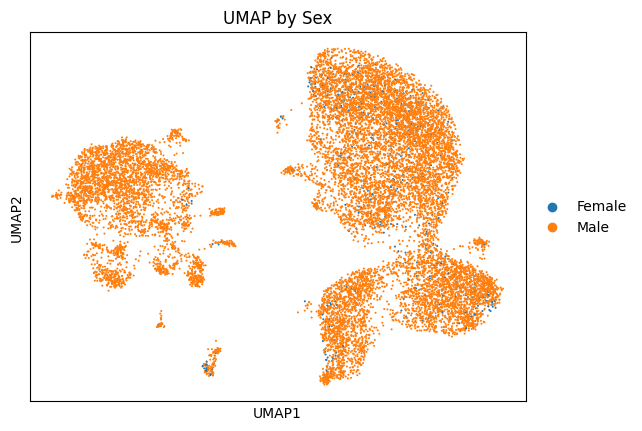

In [170]:
sc.pl.umap(adata, color="Sex", title="UMAP by Sex")

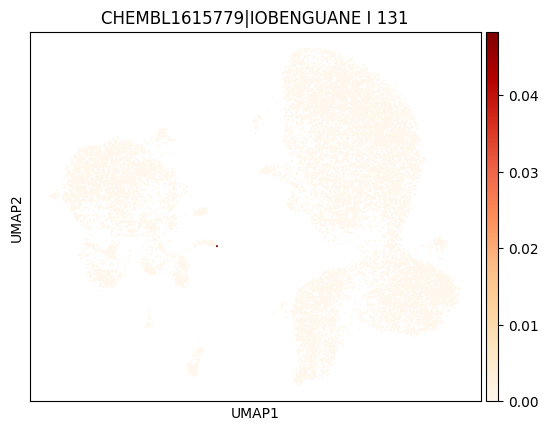

In [171]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1615779|IOBENGUANE I 131", color_map="OrRd")

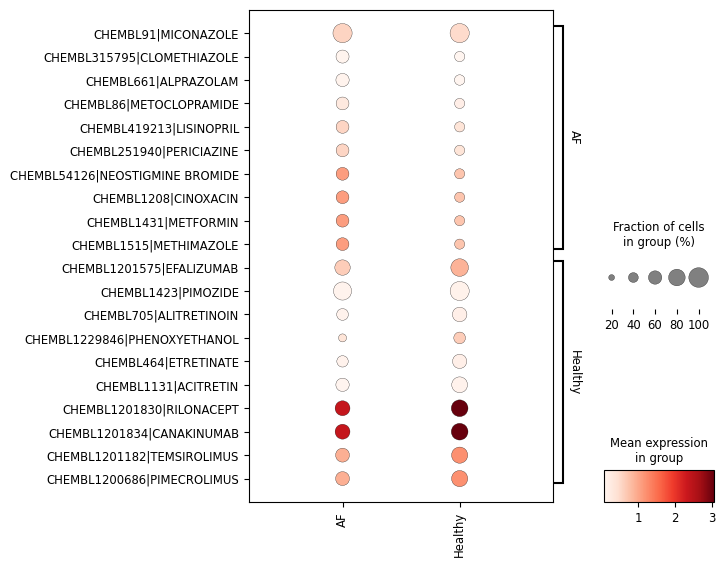

In [175]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="Disease")
sc.pl.rank_genes_groups_dotplot(adata.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=10, figsize=(6,6))


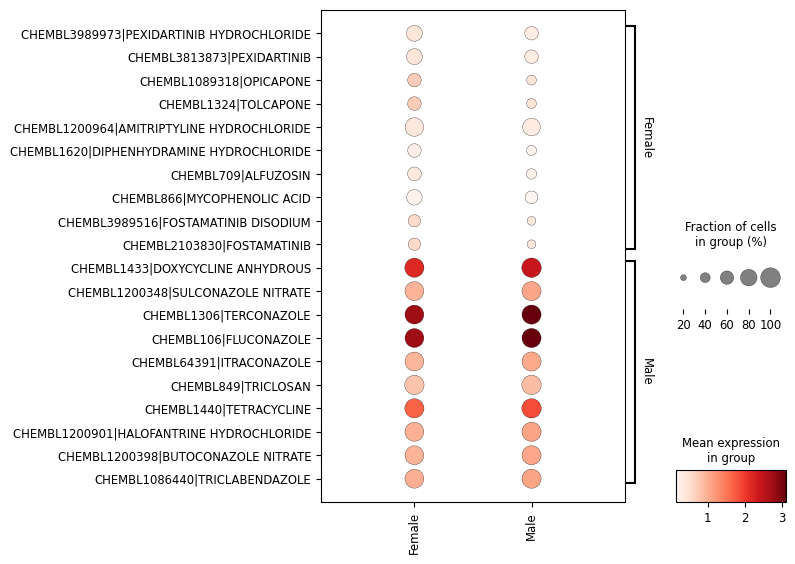

In [174]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="Sex")
sc.pl.rank_genes_groups_dotplot(adata.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=10, figsize=(6,6))

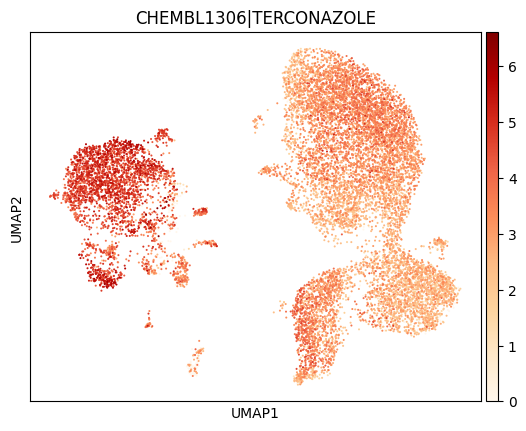

In [141]:

sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1306|TERCONAZOLE", color_map="OrRd")

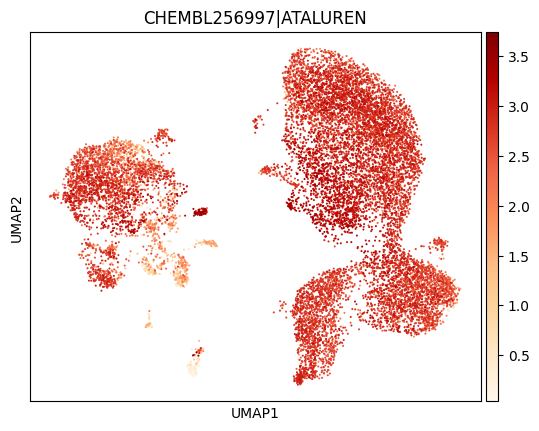

In [177]:

sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL256997|ATALUREN", color_map="OrRd")

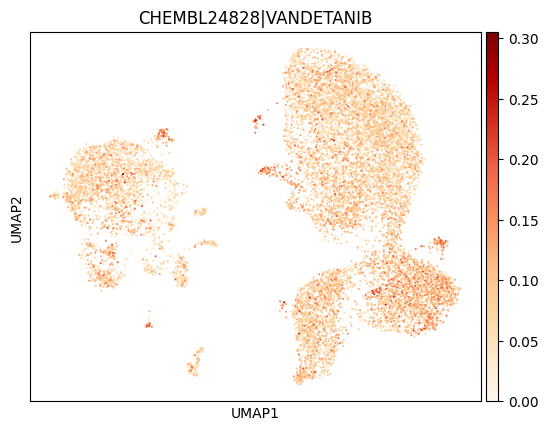

In [176]:
# Reduces Inflammatory Cytokines
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL24828|VANDETANIB", color_map="OrRd")

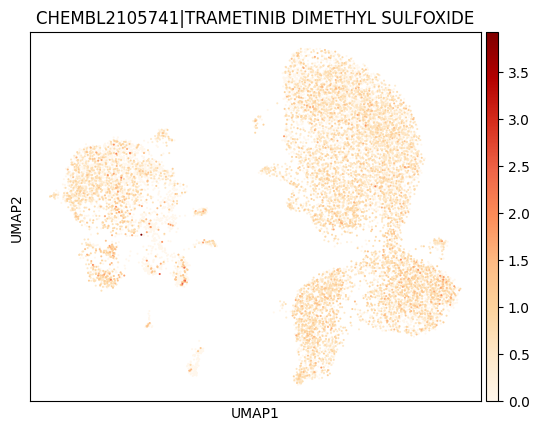

In [178]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL2105741|TRAMETINIB DIMETHYL SULFOXIDE", color_map="OrRd")

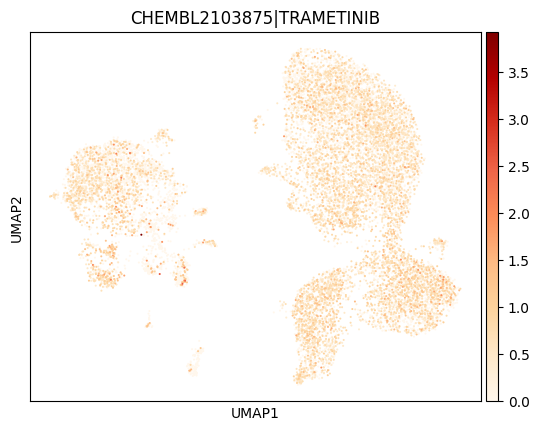

In [179]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL2103875|TRAMETINIB", color_map="OrRd")

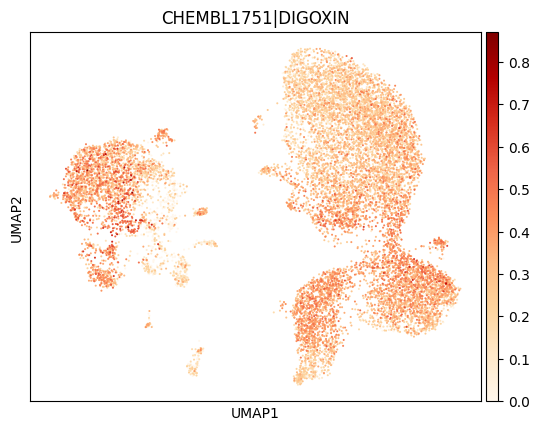

In [180]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1751|DIGOXIN", color_map="OrRd")

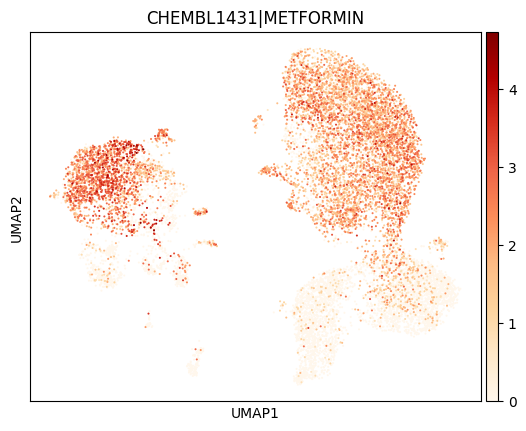

In [181]:
sc.pl.umap(adata.uns['drug2cell'], color="CHEMBL1431|METFORMIN", color_map="OrRd")

In [185]:
sc.get.rank_genes_groups_df(adata.uns['drug2cell'], group = 'Healthy')


names     scores  logfoldchanges          pvals  \
0         CHEMBL1201575|EFALIZUMAB  21.849577        0.688278  7.845695e-106   
1              CHEMBL1423|PIMOZIDE  16.917595        0.312842   3.337876e-64   
2           CHEMBL705|ALITRETINOIN  16.400330        0.639000   1.902055e-60   
3     CHEMBL1229846|PHENOXYETHANOL  16.267904        1.039848   1.667704e-59   
4             CHEMBL464|ETRETINATE  16.190292        0.654938   5.904690e-59   
...                            ...        ...             ...            ...   
2278       CHEMBL419213|LISINOPRIL -14.019190       -0.752660   1.189652e-44   
2279       CHEMBL86|METOCLOPRAMIDE -14.025899       -0.681892   1.082327e-44   
2280          CHEMBL661|ALPRAZOLAM -14.183189       -0.612536   1.164324e-45   
2281    CHEMBL315795|CLOMETHIAZOLE -14.403851       -0.641278   4.893914e-47   
2282           CHEMBL91|MICONAZOLE -14.800111       -0.269407   1.462424e-49   

          pvals_adj  
0     1.791172e-102  
1      3.810185e-61  
2      1.447464e-57  
3      9.518420e-57  
4      2.696081e-56  
...             ...  
2278   1.086391e-42  
2279   1.029563e-42  
2280   1.208251e-43  
2281   5.320384e-45  
2282   1.669357e-47  

[2283 rows x 5 columns]

In [184]:
sc.get.rank_genes_groups_df(adata.uns['drug2cell'], group = 'AF')

names     scores  logfoldchanges          pvals  \
0              CHEMBL91|MICONAZOLE  14.800111        0.269407   1.462424e-49   
1       CHEMBL315795|CLOMETHIAZOLE  14.403851        0.641278   4.893914e-47   
2             CHEMBL661|ALPRAZOLAM  14.183189        0.612536   1.164324e-45   
3          CHEMBL86|METOCLOPRAMIDE  14.025899        0.681892   1.082327e-44   
4          CHEMBL419213|LISINOPRIL  14.019190        0.752660   1.189652e-44   
...                            ...        ...             ...            ...   
2278          CHEMBL464|ETRETINATE -16.190292       -0.654938   5.904690e-59   
2279  CHEMBL1229846|PHENOXYETHANOL -16.267904       -1.039848   1.667704e-59   
2280        CHEMBL705|ALITRETINOIN -16.400330       -0.639000   1.902055e-60   
2281           CHEMBL1423|PIMOZIDE -16.917595       -0.312842   3.337876e-64   
2282      CHEMBL1201575|EFALIZUMAB -21.849577       -0.688278  7.845695e-106   

          pvals_adj  
0      1.669357e-47  
1      5.320384e-45  
2      1.208251e-43  
3      1.029563e-42  
4      1.086391e-42  
...             ...  
2278   2.696081e-56  
2279   9.518420e-57  
2280   1.447464e-57  
2281   3.810185e-61  
2282  1.791172e-102  

[2283 rows x 5 columns]